In this notebook, we will briefly review some of the key concepts of linear unsupervised learning, including Principal Component Analysis (PCA) and the effects of regularizations on linear decompositions, such as SparsePCA and Non-negative Matrix Factorization (NMF). We will use a set of airfoil geometries to demonstrate these effects visually. For those who need to refresh their memory on basic concepts around Matrices and how they affect data, you can see visual examples in [Appendix C](../appendices/review_of_singular_value_decomposition.ipynb)

In [1]:
import numpy as np
import ipywidgets as widgets
import requests
import io
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Download the airfoil dataset from GitHub
url = "https://github.com/IDEALLab/ML4ME_Textbook/raw/main/part1/airfoil_interp_uniform.npy"

# Download the data file
response = requests.get(url)
response.raise_for_status()  # raise an error if download failed

# Load into numpy array
X_airfoils = np.load(io.BytesIO(response.content))



First, let's load some airfoil geometry coordinates, take a look at the shape of the data matrix, and pick a random one to visualize:

The shape of the airfoil dataset is (1528, 192, 2)


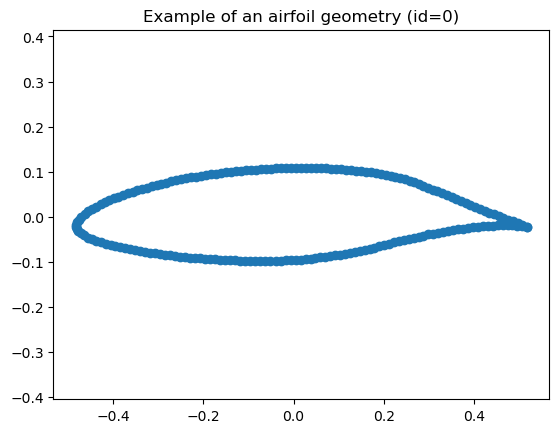

In [2]:
# Reshape the matrix so that it is N by D
# where D is the X and Y coordinates concantinated together
def make_matrix(X): return np.reshape(X, (X.shape[0], -1))
def make_airfoils(X): return X.reshape((X.shape[0], -1, 2))
def make_airfoil(X): return X.reshape((-1, 2))

# Centering the airfoils
X_airfoils[:,:,0] -= X_airfoils[:,:,0].mean()
X_airfoils[:,:,1] -= X_airfoils[:,:,1].mean()

print(f"The shape of the airfoil dataset is {X_airfoils.shape}")

# Split training and test data
test_split = 0.8
N = X_airfoils.shape[0]
split = int(N*test_split)
X_train = X_airfoils[:split]

#### You can select a different Airfoil here if you want:
airfoil_id = 0
#####################

plt.figure()
plt.scatter(X_airfoils[airfoil_id,:,0],
            X_airfoils[airfoil_id,:,1])
plt.axis('equal')
plt.title(f"Example of an airfoil geometry (id={airfoil_id})")
plt.show()

Great, as we can see there are 1528 airfoils, expressed as 192 surface coordinates each with an x and y value. We can turn this into a matrix compatible with a linear decomposition by flattening the last two dimensions, so that each airfoil is a row vector of length 384 (2x192).

Matrix Shape: (1222, 384)
Airfoils Data Shape: (1222, 192, 2)


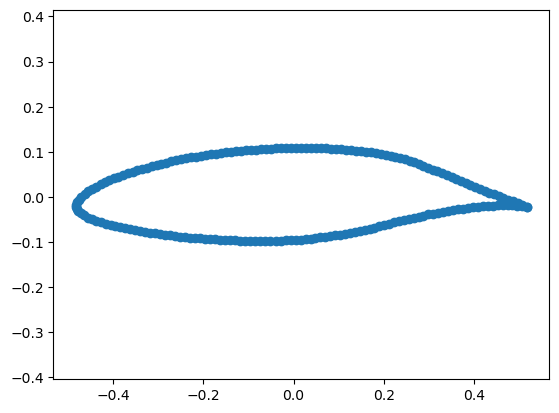

In [3]:
#| code-fold: false
X_train = make_matrix(X_train)
print("Matrix Shape:",X_train.shape)
data = X_train

# Transform back to original shape for plotting
# That is, make it back to N by 192 by 2
airfoils = make_airfoils(X_train)
print("Airfoils Data Shape:",airfoils.shape)
plt.figure()
plt.scatter(airfoils[airfoil_id,:,0],
            airfoils[airfoil_id,:,1])
plt.axis('equal')
plt.show()

Now let's demonstrate how to use various dimension reduction algorithms on this example.

## Principal Component Analysis

Mathematically, given centered data $X \in R^{n×d}$, PCA finds k orthonormal components that best reconstruct the data in least-squares sense. One convenient formulation is

$$
\min_{W,Z}\;\|X - Z W\|_{F}^{2}\quad\text{s.t. }Z=XW^{T},\;W W^{T}=I.
$$ 

Equivalently PCA maximizes the projected variance:

$$
\max_{W:\;W W^{T}=I} \;\mathrm{tr}(W \Sigma W^{T}),\quad \Sigma=\frac{1}{n}X^{T}X.
$$ 

Notes:

- There is no explicit L1/L2 penalty in vanilla PCA; the constraint $W W^{T}=I$ enforces orthonormality of components.
- The analytical solution is given by the top-k eigenvectors of the covariance (or the top-k left/right singular vectors from SVD).

In [4]:
#| code-fold: false
from sklearn import decomposition

# We can set the maximum number of components that we want to truncate to
# Or can just leave it as None to get all components
n_components = 20
estimator = decomposition.PCA(n_components=n_components)
Z_pca = estimator.fit_transform(data)
components_ = estimator.components_

We see that we now possess a matrix (i.e., linear operator) that goes from the target 20 components/dimensions back to the original 382 dimensions.

In [5]:
#| code-fold: false
print(f"The shape of the components_ matrix (W) is {components_.shape}")

The shape of the components_ matrix (W) is (20, 384)


If we wanted to visualize how each of these components looks like in terms of the original airfoil coordinates, we can reshape each row of the components matrix back to the original airfoil shape:

In [6]:
#| code-fold: false
components_.reshape((n_components, -1, 2)).shape

(20, 192, 2)

Let's go ahead and visualize the first all of the learned components:

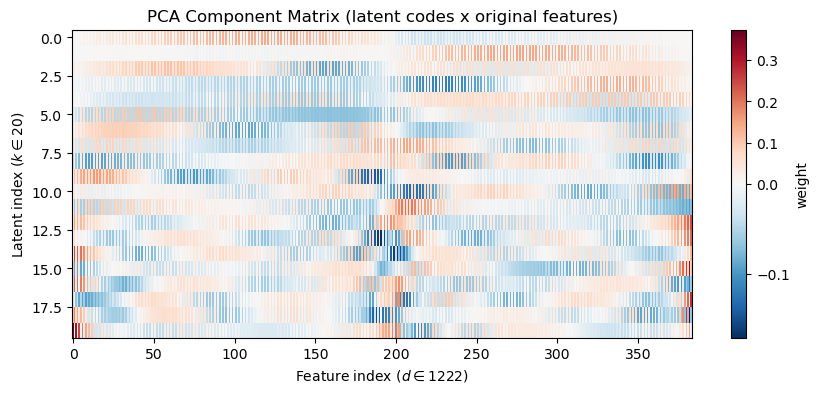

In [7]:
# Component heatmap
plt.figure(figsize=(10,4))
plt.imshow(components_, aspect='auto', cmap='RdBu_r', interpolation='nearest', 
           norm=TwoSlopeNorm(vmin=components_.min(), vcenter=0, vmax=components_.max()))
plt.colorbar(label='weight')
plt.xlabel(f"Feature index ($d \\in {Z_pca.shape[0]}$)")
plt.ylabel(f"Latent index ($k \\in {Z_pca.shape[1]}$)")
plt.title('PCA Component Matrix (latent codes x original features)')
plt.show()

We notice a kind of alternating aliasing pattern in the components, but recall, this is because of how we reshaped the original data, which had rows of x and y coordinates interleaved. To make this clearer, we can visually re-order the indices of the components so that all the x-coordinates come first (first 192 features), followed by all the y-coordinates (second 192 features):

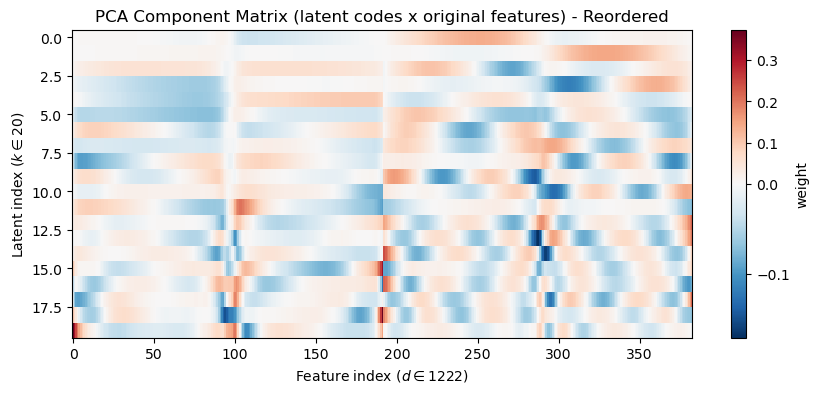

In [8]:
# make an array with all of the odd indices of components_
def reorder_indices(components):
    return np.hstack([components[:,0:-1:2],components[:,1:-1:2]])

# Component heatmap
plt.figure(figsize=(10,4))
plt.imshow(reorder_indices(components_), aspect='auto', cmap='RdBu_r', interpolation='nearest', 
           norm=TwoSlopeNorm(vmin=components_.min(), vcenter=0, vmax=components_.max()))
plt.colorbar(label='weight')
plt.xlabel(f"Feature index ($d \\in {Z_pca.shape[0]}$)")
plt.ylabel(f"Latent index ($k \\in {Z_pca.shape[1]}$)")
plt.title('PCA Component Matrix (latent codes x original features) - Reordered')
plt.show()

OK, this now looks a little clearer. What do you notice?

We can next visualize how each data point is mapped to all of the latent coordinates:

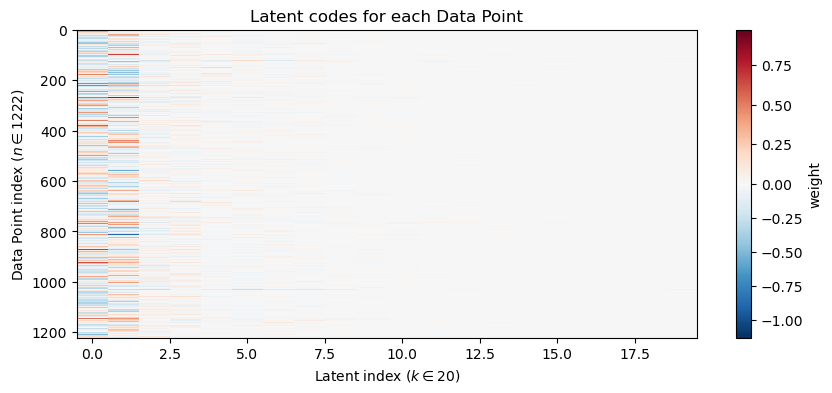

In [9]:
# Latent Coordinate heatmap
plt.figure(figsize=(10,4))
plt.imshow(Z_pca, aspect='auto', cmap='RdBu_r', interpolation='nearest',
           norm=TwoSlopeNorm(vmin=Z_pca.min(), vcenter=0, vmax=Z_pca.max()))
plt.colorbar(label='weight')
plt.xlabel(f"Latent index ($k \\in {Z_pca.shape[1]}$)")
plt.ylabel(f"Data Point index ($n \\in {Z_pca.shape[0]}$)")
plt.title('Latent codes for each Data Point')
plt.show()

Why do you think the first few components are more important than the later ones? We can gain some intuition here by looking at the amount of variance explained by each component:

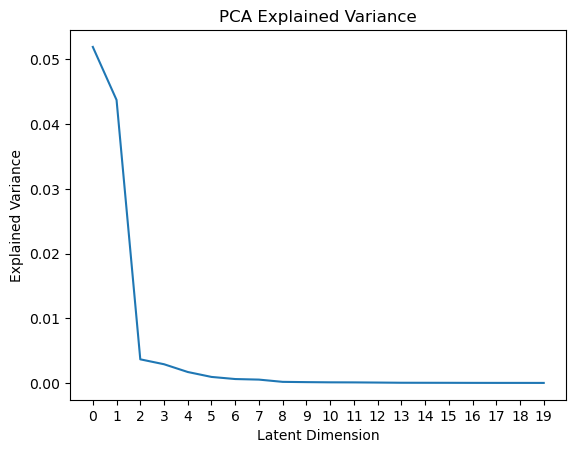

In [10]:
plt.figure()
plt.plot(estimator.explained_variance_)
plt.ylabel("Explained Variance")
plt.xlabel("Latent Dimension")
plt.title("PCA Explained Variance")
plt.xticks(np.arange(n_components))
plt.show()

We can also visualize the cumulative explained variance to see how many components are needed to explain a certain amount of variance in the data. For example, we can plot a line at the number of dimensions we need to keep to explain 99% of the variance:

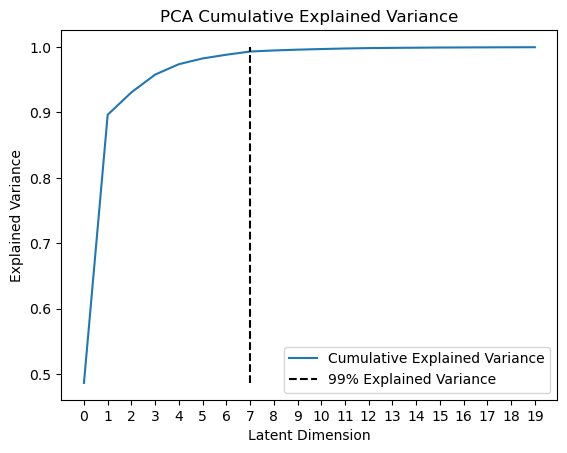

In [11]:
cumulative_explained_var_ratio = np.cumsum(estimator.explained_variance_ratio_)
number_of_vars_to_99 = np.argmax(cumulative_explained_var_ratio>.99)
plt.figure()
plt.plot(cumulative_explained_var_ratio,label="Cumulative Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Latent Dimension")
plt.xticks(np.arange(n_components))
plt.vlines(number_of_vars_to_99,
           np.min(cumulative_explained_var_ratio),1.0,
           colors="k",linestyles='dashed',
          label = "99% Explained Variance")
plt.legend()
plt.title("PCA Cumulative Explained Variance")
plt.show()

Or plot the explained variance ratio as a function of the number of components, which tells us how much each additional component contributes to the total explained variance:

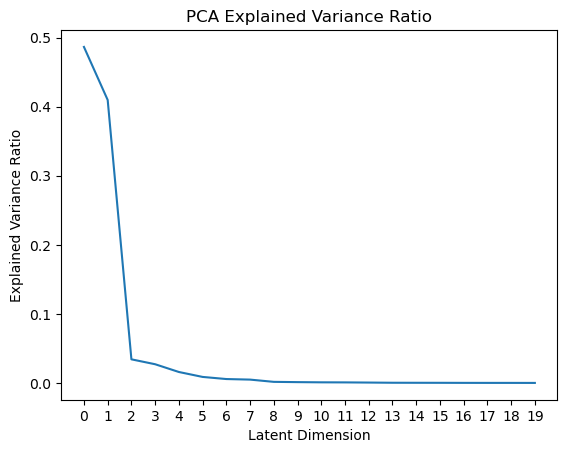

In [12]:
plt.figure()
plt.plot(estimator.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Latent Dimension")
plt.xticks(np.arange(n_components))
plt.title("PCA Explained Variance Ratio")
plt.show()

We can see that this approximately follows the singular values of the data matrix:

Singular Values: [7.96347431 7.30793278 2.11271967 1.880563   1.43978062 1.06857152
 0.86184436 0.79754077 0.46006406 0.40013427 0.3503857  0.33218949
 0.28107742 0.20708862 0.19063632 0.17582911 0.14392864 0.1288838
 0.12505431 0.10367465]


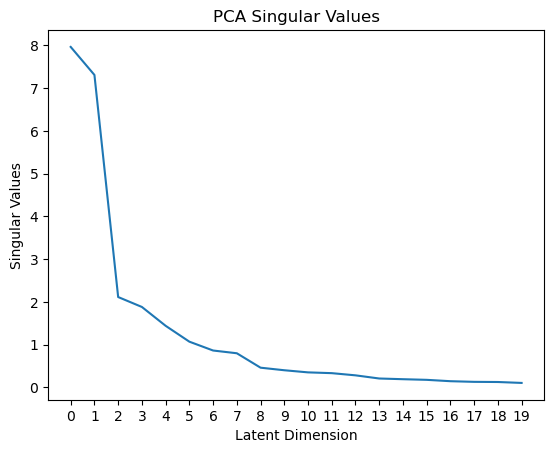

In [13]:
print(f"Singular Values: {estimator.singular_values_}")
plt.figure()
plt.plot(estimator.singular_values_)
plt.ylabel("Singular Values")
plt.xlabel("Latent Dimension")
plt.xticks(np.arange(n_components))
plt.title("PCA Singular Values")
plt.show()

Moving beyond just the singular values, we can also now look at the projection of each airfoil into any of the latent dimensions. It is natural to explore the first two, since those explain the largest variance:

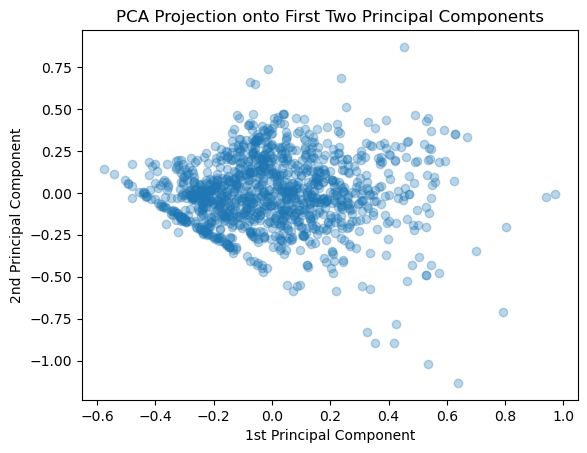

In [14]:
z = estimator.transform(data)
plt.figure()
plt.scatter(z[:,0],z[:,1],alpha=0.3)
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")   
plt.title("PCA Projection onto First Two Principal Components")
plt.show()  

We can also pull out the "latent code/coordinates/vector" for an individual airfoil:

In [15]:
#| code-fold: false
z[airfoil_id,:]

array([ 0.26565954, -0.30692116,  0.18797174, -0.0349173 , -0.0307379 ,
        0.02908489, -0.02403219,  0.02460046, -0.01230913, -0.0146706 ,
        0.0124125 ,  0.00509173, -0.01270168,  0.00192036, -0.00573131,
        0.00744313,  0.00506638,  0.00798497,  0.01136562,  0.00033123])

### How does the # Components affect the Airfoil Reconstruction?

We can see visually the effect of including an increasing number of components by looking at how this affects the reconstruction of a single airfoil:

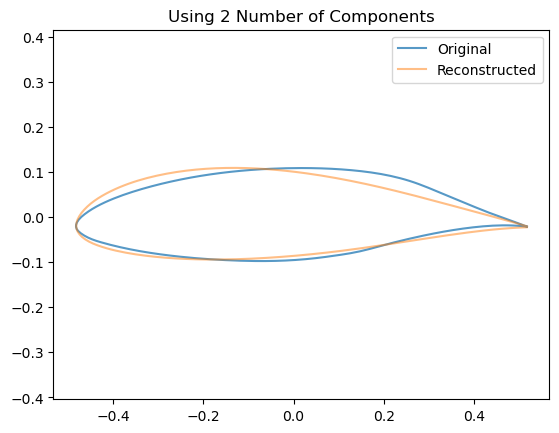

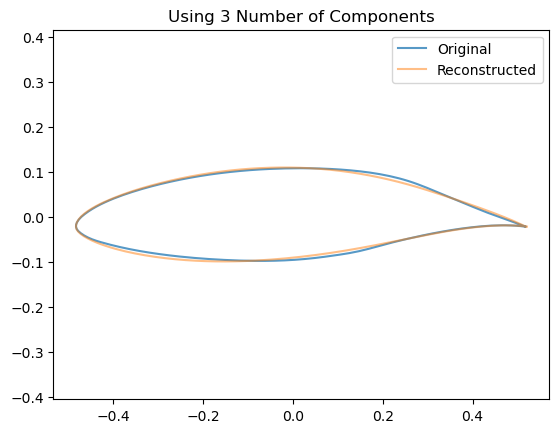

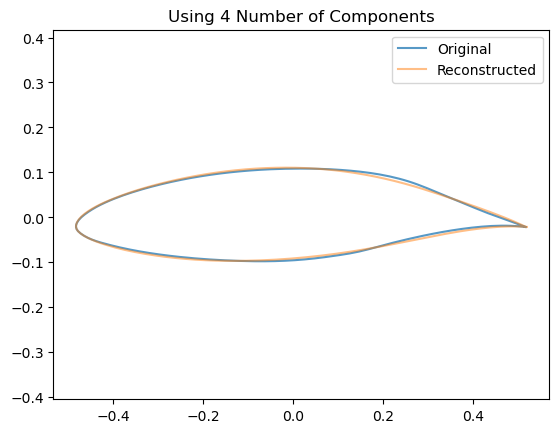

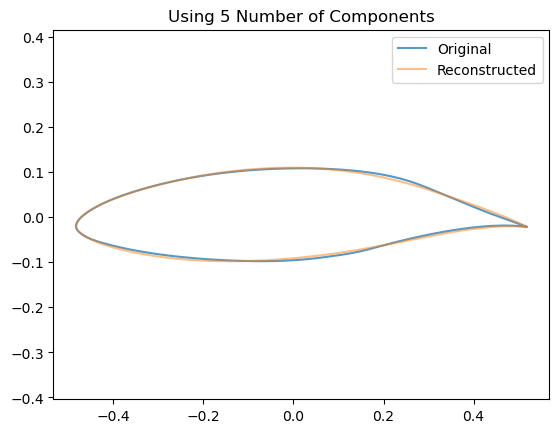

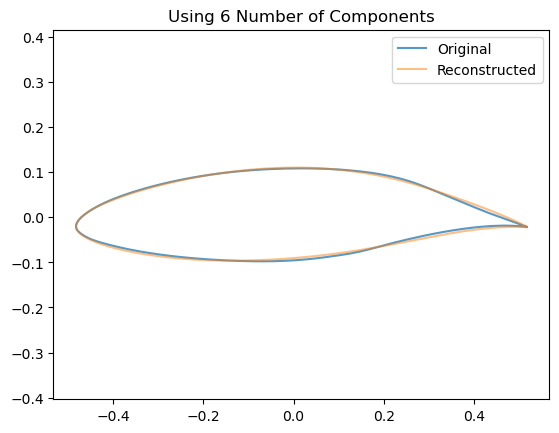

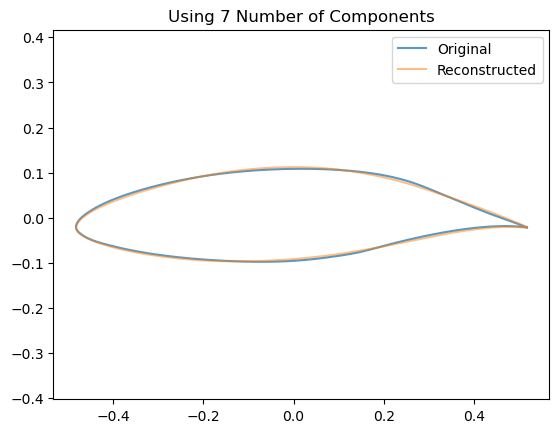

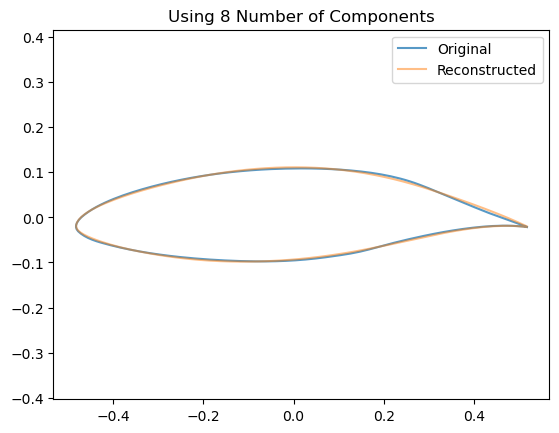

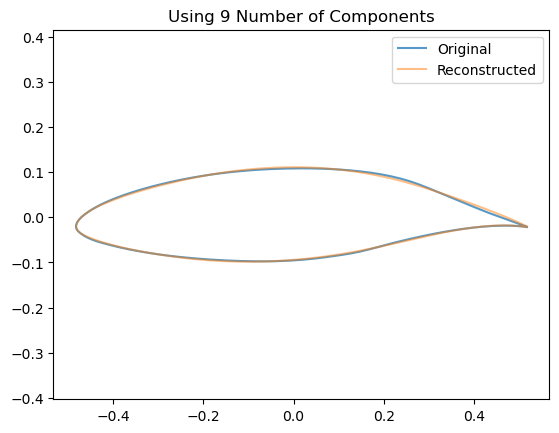

In [16]:
for n_components in range(2,10):
    estimator = decomposition.PCA(n_components=n_components, whiten=False)
    
    # Train the model
    estimator.fit(data)
    # Project down to the low dimensional space
    z     = np.dot(data - estimator.mean_, estimator.components_.T)
    # Re-Project back to the high dimensional space
    x_hat = np.dot(z[0], estimator.components_) + estimator.mean_

    # Now plot them
    airfoil_original = make_airfoil(data[0])
    airfoil_reconstructed = make_airfoil(x_hat)
    airfoil_mean = make_airfoil(estimator.mean_)
    plt.figure()
    plt.plot(airfoil_original[:,0],
             airfoil_original[:,1],
             alpha=0.75,
             label = 'Original')
    plt.plot(airfoil_reconstructed[:,0],
                airfoil_reconstructed[:,1],
                alpha=0.5,
                label='Reconstructed')

    plt.title(f"Using {n_components} Number of Components")
    plt.legend()
    plt.axis('equal')
    plt.show()


In [17]:

# Interactive top-k overlay for contribution
if widgets is not None:
    top_k_slider = widgets.IntSlider(value=1, min=1, max=9, step=1, description='top_k')
    def show_topk(k=4):
        # Find the first k principal components and multiply them with the corresponding latent variables
        contrib = np.dot(z[airfoil_id,:k], components_[:k,:])+ estimator.mean_
        plt.figure(figsize=(6,3))
        plt.plot(make_airfoil(data[airfoil_id])[:,0], make_airfoil(data[airfoil_id])[:,1], label='Original', alpha=0.6)
        plt.plot(make_airfoil(contrib)[:,0], make_airfoil(contrib)[:,1], label='Top-k contribution', color='C3')
        plt.plot(make_airfoil(data.mean(axis=0))[:,0], make_airfoil(data.mean(axis=0))[:,1], '-', color='g', label='Mean')
        plt.axis('equal')
        plt.title(f'Top-{k} component contributions (overlay)')
        plt.legend()
        plt.show()
    display(widgets.VBox([top_k_slider, widgets.interactive_output(show_topk, {'k': top_k_slider})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually.')

In [18]:
# Interactive visualization of each component
if widgets is not None:
    component_selector = widgets.IntSlider(value=1, min=1, max=n_components, step=1, description='component')
    def show_component(k=4):
        # Find the first k principal components and multiply them with the corresponding latent variables
        #contrib = np.dot(z[airfoil_id,:k], components_[:k,:])+ estimator.mean_
        plt.figure(figsize=(6,5))
        selected_component = components_[k-1,:]+ estimator.mean_
        plt.plot(make_airfoil(selected_component)[:,0], make_airfoil(selected_component)[:,1], label='Component', alpha=1.0)
        plt.axis('equal')
        plt.title(f'Component {k}')
        plt.xlim(-0.6,0.6)
        plt.show()
    display(widgets.VBox([component_selector, widgets.interactive_output(show_component, {'k': component_selector})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually.')

## Sparse PCA

Sparse PCA encourages components that have many zeros, which can make the learned components easier to interpret as localized shape features. Below we fit a SparsePCA model and visualize a small set of sparse components and their effect on reconstructing an example airfoil.

Mathematically, Sparse PCA augments a PCA-style reconstruction loss with an L1 penalty on the (unconstrained) components to encourage sparsity. A common optimization is:

$$\min_{Z,W}\;\|X - ZW\|_{F}^{2} + \alpha\|W\|_{1}\quad\text{s.t. }\|Z_{i}\|_{2}^{2}\le 1\;\forall i,\,$$

where $W \in R^{k×d}$ holds the component vectors (rows), $Z \in R^{n×k}$ are the codes, and $\alpha>0$ controls sparsity. Different implementations (e.g., the sklearn SparsePCA) solve related objectives (sometimes using a LASSO subproblem or elastic-net style updates).

Notes:

- The L1 term on W encourages many component weights to be exactly zero, producing localized/part-like components.
- In practice one often also adds a small L2 (ridge) term to stabilize optimization (an elastic-net variant).

In [19]:
#| code-fold: false
from sklearn.decomposition import SparsePCA

#### Try Changing both n_components and alpha  ########
n_components = 12
# Warning: setting alpha too low will take the algorithm a long time to converge
alpha = 0.01
##########################
spca = SparsePCA(n_components=n_components, alpha=alpha, random_state=42)
# fit on the flattened data matrix 'data' used above
spca.fit(data)
W_sp = spca.components_
Z_sp = spca.transform(data)


Now let's take a look at what the Sparse PCA model has learned and how it reconstructs the example airfoil differently than vanilla PCA:

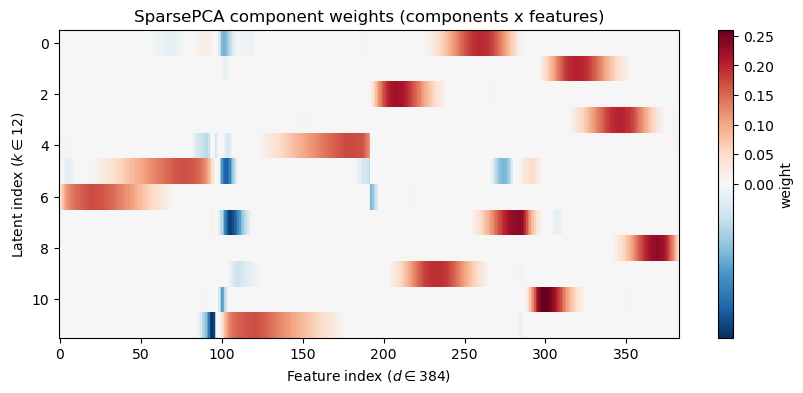

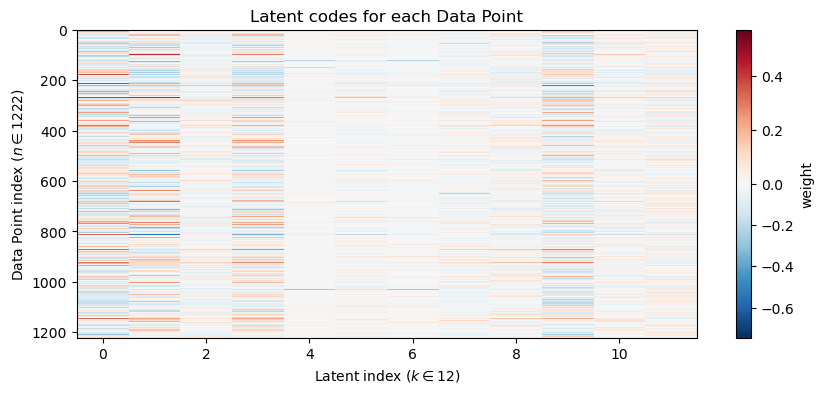

In [20]:
# Component heatmap (components x features)
plt.figure(figsize=(10,4))
plt.imshow(reorder_indices(W_sp), aspect='auto', cmap='RdBu_r', interpolation='nearest',
           norm=TwoSlopeNorm(vmin=W_sp.min(), vcenter=0, vmax=W_sp.max()))
plt.colorbar(label='weight')
plt.ylabel(f"Latent index ($k \\in {W_sp.shape[0]}$)")
plt.xlabel(f"Feature index ($d \\in {W_sp.shape[1]}$)")
plt.title('SparsePCA component weights (components x features)')
plt.show()

# Latent Coordinate heatmap
plt.figure(figsize=(10,4))
plt.imshow(Z_sp, aspect='auto', cmap='RdBu_r', interpolation='nearest',
           norm=TwoSlopeNorm(vmin=Z_sp.min(), vcenter=0, vmax=Z_sp.max()))
plt.colorbar(label='weight')
plt.xlabel(f"Latent index ($k \\in {Z_sp.shape[1]}$)")
plt.ylabel(f"Data Point index ($n \\in {Z_sp.shape[0]}$)")
plt.title('Latent codes for each Data Point')
plt.show()

# Now let's try reconstructing an airfoil from the trained model
# Pull out the latent representation of this airfoil ID
z = Z_sp[airfoil_id]
x_hat = spca.inverse_transform(z.reshape(-1, 1).T)
# Alternatively, we could do the following manual reconstruction:
#x_hat = np.dot(z, W_sp) + data.mean(axis=0)

# Interactive visualization of each component
if widgets is not None:
    component_selector = widgets.IntSlider(value=1, min=1, max=n_components, step=1, description='component')
    def show_component(k=4):
        # Find the first k principal components and multiply them with the corresponding latent variables
        #contrib = np.dot(z[airfoil_id,:k], components_[:k,:])+ estimator.mean_
        plt.figure(figsize=(6,5))
        selected_component = W_sp[k-1,:] + data.mean(axis=0)
        plt.plot(make_airfoil(selected_component)[:,0], make_airfoil(selected_component)[:,1], label='Component', alpha=1.0)
        plt.axis('equal')
        plt.title(f'Component {k}')
        #plt.legend()
        plt.xlim(-0.6,0.6)
        #plt.ylim(-0.4,0.4)
        plt.show()
    display(widgets.VBox([component_selector, widgets.interactive_output(show_component, {'k': component_selector})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually.')

# Interactive top-k overlay for contribution
if widgets is not None:
    top_k_slider = widgets.IntSlider(value=4, min=1, max=n_components, step=1, description='top_k')
    def show_topk(k=4):
        top_idx = np.argsort(np.abs(z))[::-1][:k]
        contrib = np.sum(z[top_idx][:,None] * W_sp[top_idx], axis=0)
        plt.figure(figsize=(6,3))
        plt.plot(make_airfoil(data[airfoil_id])[:,0], make_airfoil(data[airfoil_id])[:,1], label='Original', alpha=0.6)
        plt.plot(make_airfoil(contrib + data.mean(axis=0))[:,0], make_airfoil(contrib + data.mean(axis=0))[:,1], label='Top-k contribution', color='C3')
        plt.plot(make_airfoil(data.mean(axis=0))[:,0], make_airfoil(data.mean(axis=0))[:,1], '--', color='g', label='Mean')
        plt.axis('equal')
        plt.title(f'Top-{k} component contributions (overlay)')
        plt.legend()
        plt.show()
    display(widgets.VBox([top_k_slider, widgets.interactive_output(show_topk, {'k': top_k_slider})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually.')

::: {.callout-tip appearance="default"}
### Experiment: Comparison between PCA and SparsePCA
Compare both the component weight matrix and the reconstruction of a single airfoil when we used PCA and SparsePCA.

Consider the following questions:

- What are the main differences in the component weights between PCA and SparsePCA? How does the addition of the L1 penalty within SparsePCA manifest itself in the weight matrix? How does this manifest itself in the learned components, either individually or as we add them up during reconstruction?
- Also compare the latent codes $Z$ between PCA and SparsePCA. How do they differ? What does this tell you about how the data is represented in the latent space? How about which components are most important?
- For SparsePCA, how does changing the value of the sparsity parameter $\alpha$ affect the learned components and reconstruction? What happens when we increase or decrease $\alpha$? Look at both the weight matrix and the components.
- If you set $\alpha$ very low (e.g., 0.001) and increase the number of components, how does the result compare to vanilla PCA with the same number of components? What would you expect to happen, comparing the loss functions? Why are they different?
- Under what practical circumstances or for what types of problems might SparsePCA be preferred over PCA and vice versa?

:::

## Dictionary Learning

Dictionary learning finds a set of atoms (basis elements) and sparse codes that reconstruct the data. This is useful when localized, part-based representations are desirable. Essentially, unlike Sparse PCA (which adds an L1 penalty to the components), dictionary learning adds an L1 penalty to the codes. Below we fit a Dictionary Learning model and visualize a small set of learned atoms and their effect on reconstructing an example airfoil.



Mathematically, Dictionary learning (sparse coding) models X as the product of a dictionary $W \in R^{k×d}$ (atoms) and sparse codes $Z \in R^{n×k}$:

$$
\min_{Z,W}\;\|X - Z W\|_{F}^{2} + \alpha\|Z\|_{1} \,\quad\text{s.t. }\|W_{j}\|_{2}\le 1\; \forall j.
$$ 

Here Z contains the sparse coefficients for each example and $\alpha>0$ controls the sparsity of the codes. The constraint on $W$ prevents trivial scaling to reduce the penalty term (i.e., just pulling weight into W and shrinking Z). Intuitively, each data point is reconstructed as a *sparse* linear combination of dictionary atoms, essentially selecting a few "parts" (where the parts are elements of $W$) to compose the whole as a weighted sum.

Notes:

- The L1 penalty acts on the coefficients (Z) rather than $W$ to encourage sparse usage of dictionary elements.
- Many algorithms alternate between solving for Z (a LASSO-type problem) and updating W (a constrained least-squares step).

In [21]:
#| code-fold: false
# Warning, running this particular cell takes a long time as the sklearn implementation 
# is not particularly fast. (~4-8 mins)
from sklearn.decomposition import DictionaryLearning
# Alternatively, you can use the MiniBatchDictionaryLearning which is faster, but less accurate or stable:
#from sklearn.decomposition import MiniBatchDictionaryLearning as DictionaryLearning


### Try changing n_components and alpha ########
n_components = 10
alpha = 0.1
##########################

DL = DictionaryLearning(n_components=n_components, alpha=alpha, random_state=42)
Z_dl = DL.fit_transform(data)
W_dl = DL.components_


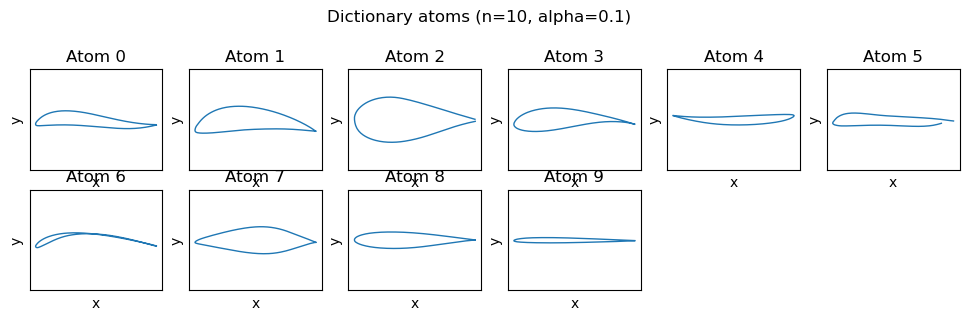

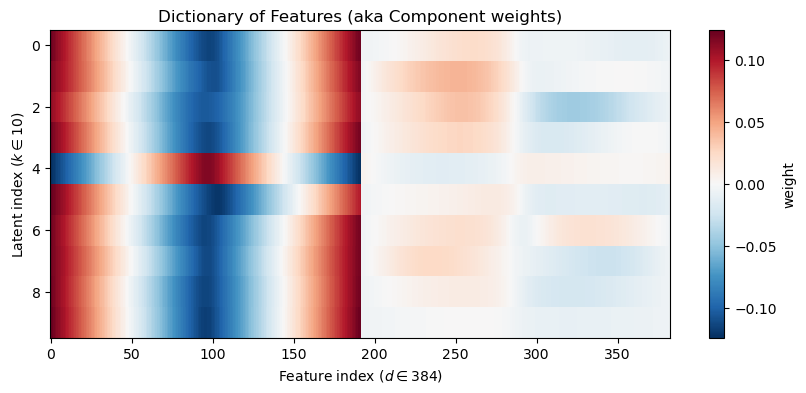

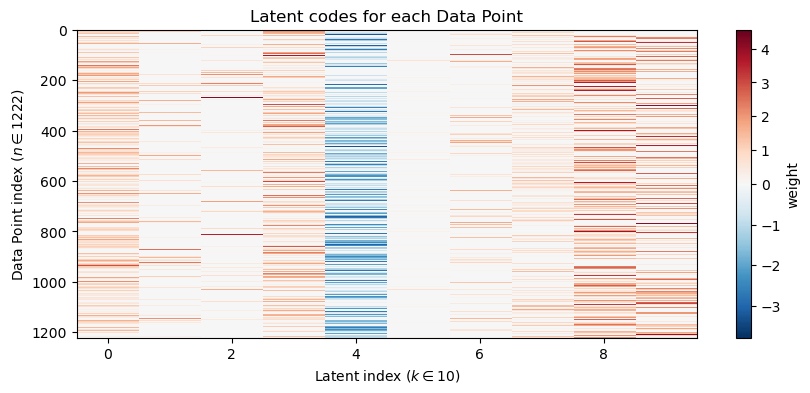

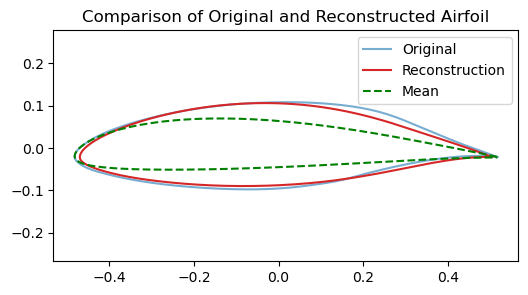

Average fraction of near-zero coefficients: 0.540


In [22]:
# Visualize first few atoms
plt.figure(figsize=(12,6))
for i in range(n_components):
    plt.subplot(4,6,i+1)
    xy = make_airfoil(W_dl[i])
    plt.plot(xy[:,0], xy[:,1], lw=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Atom {i}')
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
plt.suptitle(f'Dictionary atoms (n={n_components}, alpha={alpha})')
plt.show()

# Component heatmap
plt.figure(figsize=(10,4))
plt.imshow(reorder_indices(W_dl), aspect='auto', cmap='RdBu_r', interpolation='nearest',
           norm=TwoSlopeNorm(vmin=W_dl.min(), vcenter=0, vmax=W_dl.max()))
plt.colorbar(label='weight')
plt.ylabel(f"Latent index ($k \\in {n_components}$)")
plt.xlabel(f"Feature index ($d \\in {W_dl.shape[1]}$)")
plt.title('Dictionary of Features (aka Component weights)')
plt.show()

# Latent Coordinate heatmap
plt.figure(figsize=(10,4))
plt.imshow(Z_dl, aspect='auto', cmap='RdBu_r', interpolation='nearest',
           norm=TwoSlopeNorm(vmin=Z_dl.min(), vcenter=0, vmax=Z_dl.max()))
plt.colorbar(label='weight')
plt.xlabel(f"Latent index ($k \\in {n_components}$)")
plt.ylabel(f"Data Point index ($n \\in {Z_dl.shape[0]}$)")
plt.title('Latent codes for each Data Point')
plt.show()

# Reconstruction an airfoil using the learned codes
x_hat = np.dot(Z_dl[airfoil_id], W_dl)
plt.figure(figsize=(6,3))
plt.plot(make_airfoil(data[airfoil_id])[:,0], make_airfoil(data[airfoil_id])[:,1], label='Original', alpha=0.6)
plt.plot(make_airfoil(x_hat)[:,0], make_airfoil(x_hat)[:,1], label='Reconstruction', color='C3')
plt.plot(make_airfoil(data.mean(axis=0))[:,0], make_airfoil(data.mean(axis=0))[:,1], '--', color='g', label='Mean')
plt.axis('equal')
plt.title('Comparison of Original and Reconstructed Airfoil')
plt.legend()
plt.show()

# Interactive top-k atoms display
if widgets is not None:
    top_k_slider = widgets.IntSlider(value=6, min=1, max=n_components, step=1, description='top_k')
    def show_top_atoms(k=6):
        top_idx = np.argsort(np.abs(Z_dl[airfoil_id]))[::-1][:k]
        plt.figure(figsize=(8,4))
        for i, idx in enumerate(top_idx):
            plt.subplot(1,k,i+1)
            plt.plot(make_airfoil(W_dl[idx])[:,0], make_airfoil(W_dl[idx])[:,1])
            plt.axis('equal')
            plt.title(f'atom {idx}')
            plt.xticks([])
            plt.yticks([])
        plt.suptitle('Top atoms used for this example')
        plt.show()
    display(widgets.VBox([top_k_slider, widgets.interactive_output(show_top_atoms, {'k': top_k_slider})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually.')

# Interactive top-k overlay for contribution
if widgets is not None:
    top_k_slider = widgets.IntSlider(value=4, min=1, max=8, step=1, description='top_k')
    def show_topk(k=4):
        top_idx = np.argsort(np.abs(Z_dl[airfoil_id]))[::-1][:k]
        #contrib = np.sum(z[top_idx][:,None] * W_sp[top_idx], axis=0)
        contrib = np.sum(Z_dl[airfoil_id,top_idx][:,None] * W_dl[top_idx], axis=0)
        plt.figure(figsize=(6,3))
        plt.plot(make_airfoil(data[airfoil_id])[:,0], make_airfoil(data[airfoil_id])[:,1], label='Original', alpha=0.6)
        #plt.plot(make_airfoil(contrib + data.mean(axis=0))[:,0], make_airfoil(contrib + data.mean(axis=0))[:,1], label='Top-k contribution', color='C3')
        plt.plot(make_airfoil(contrib)[:,0], make_airfoil(contrib)[:,1], label='Top-k contribution', color='C3')
        plt.plot(make_airfoil(data.mean(axis=0))[:,0], make_airfoil(data.mean(axis=0))[:,1], '--', color='g', label='Mean')
        plt.axis('equal')
        plt.title(f'Top-{k} component contributions (overlay)')
        plt.legend()
        plt.show()
    display(widgets.VBox([top_k_slider, widgets.interactive_output(show_topk, {'k': top_k_slider})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually.')

# Show sparsity level of codes
sparsity = np.mean(np.abs(Z_dl) < 1e-6)
print(f'Average fraction of near-zero coefficients: {sparsity:.3f}')

::: {.callout-tip appearance="default"}
### Experiment: Comparison between Dictionary Learning (Sparse Coding) and SparsePCA
Compare both the component weight matrix and the reconstruction of a single airfoil when we used Sparse PCA and Dictionary Learning (Sparse Coding).

Consider the following questions:

- Both algorithms use the same sparsity penalty (L1), but on different matrices. How does this difference manifest itself in the learned components and reconstructions? What happens to the component weights versus the latent codes?
- For Dictionary Learning, how does changing the value of the sparsity parameter $\alpha$ affect the learned components and reconstruction? What happens when we increase or decrease $\alpha$? Look at both the weight matrix and the components.
- Under what practical circumstances or for what types of problems might Dictionary Learning (Sparse Coding) be preferred over PCA and Sparse PCA, and vice versa?

:::

## Non-Negative Matrix Factorization (NMF)

NMF constrains both the basis elements and coefficients to be non-negative. This often yields parts-based, additive representations which can be intuitive for shape components under certain circumstances.

Mathematically, Non-negative matrix factorization approximates $X$ (with $X\gt 0$ after shift) as the product of non-negative factors $W\in R^{n×k}_{+}$ and $H \in R^{k×d}_{+}$ by minimizing reconstruction error under non-negativity constraints:

$$\min_{W\ge 0,H\ge 0}\;\|X - Z W\|_{F}^{2} + \beta_Z\|Z\|_{1} + \beta_W\|W\|_{1} + \alpha_Z\|Z\|^{2}_{F} + \alpha_W\|W\|^{2}_{F},$$

where optional L1 penalties ($\beta_Z$, $\beta_W \ge 0$) encourage sparse parts or sparse activations, and L2 penalties ($\alpha_Z$, $\alpha_W \ge 0$) encourage stability or shrinkage. The essential constraint is $W,Z \ge 0$ which induces additive, parts-based representations.

Notes:

- In this notebook we shift data by the minimum to ensure $X \ge 0$ before fitting and then undo the shift when plotting reconstructions.
- Typical solvers use multiplicative updates or alternating non-negative least squares; regularization (L1 or L2) can be added to encourage sparsity or stability.

In [23]:
#| code-fold: false
from sklearn.decomposition import NMF

#### Try changing n_components ########
n_components = 14
# This is the L2 penalty on the components
alpha_W  = 0.001
# This is the L1 ratio on the components (between 0 and 1)
# Set to 0 for pure L2, 1 for pure L1, and in between for a mix
l1_ratio = 0.001
##########################

# NMF needs non-negative data. We'll shift by the min and remember the offset.
shift = data.min()
Xpos = data - shift + 1e-6

nmf = NMF(n_components=n_components, init='nndsvda', random_state=42, max_iter=5000,
          alpha_W = alpha_W, l1_ratio=l1_ratio)
Z_nmf = nmf.fit_transform(Xpos)
W_nmf = nmf.components_


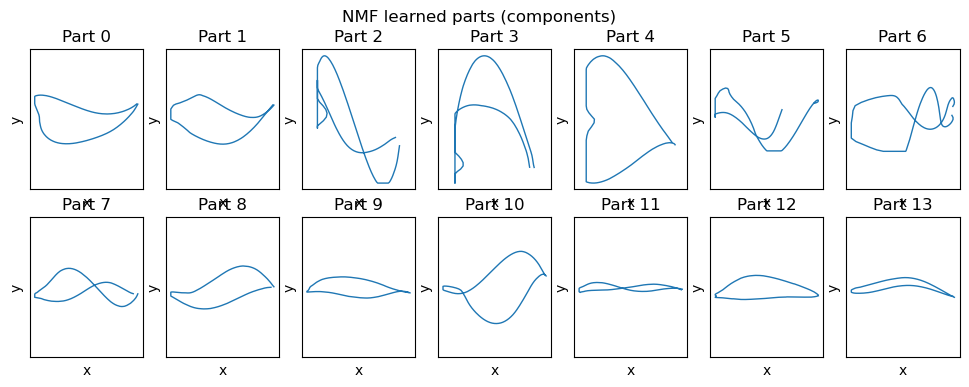

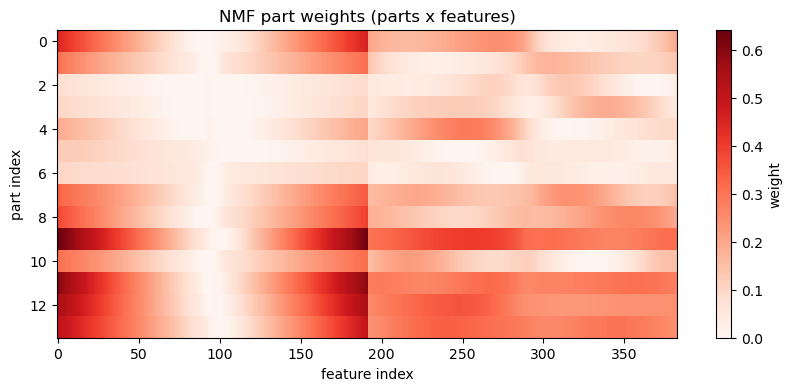

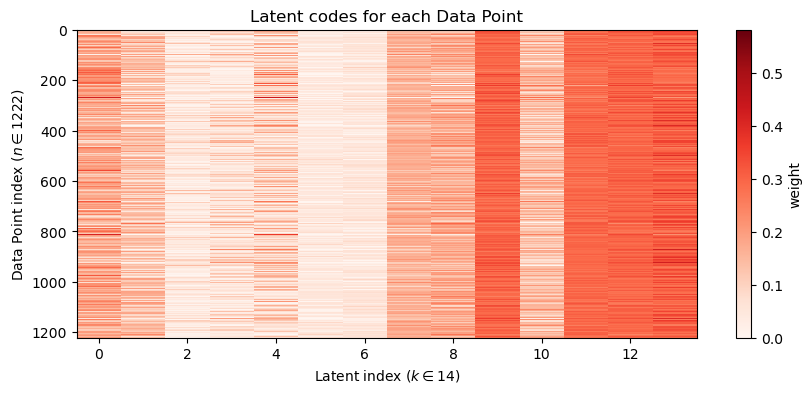

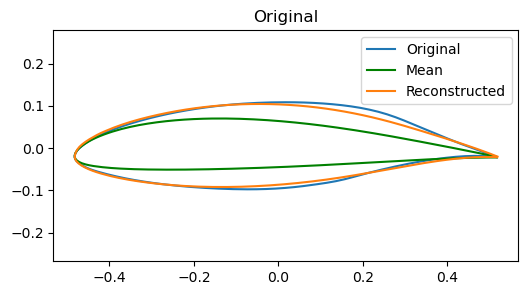

Explained variance (approx): 0.994


In [24]:
# Visualize NMF components (H) as parts
plt.figure(figsize=(12,4))
for i in range(n_components):
    plt.subplot(2, n_components//2, i+1)
    xy = make_airfoil(W_nmf[i])
    plt.plot(xy[:,0], xy[:,1], lw=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title(f'Part {i}')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('NMF learned parts (components)')
plt.show()

# Component heatmap
plt.figure(figsize=(10,4))
plt.imshow(reorder_indices(W_nmf), aspect='auto', cmap='Reds', interpolation='nearest')
plt.colorbar(label='weight')
plt.xlabel('feature index')
plt.ylabel('part index')
plt.title('NMF part weights (parts x features)')
plt.show()

# Latent Coordinate heatmap
plt.figure(figsize=(10,4))
plt.imshow(Z_nmf, aspect='auto', cmap='Reds', interpolation='nearest')
plt.colorbar(label='weight')
plt.xlabel(f"Latent index ($k \\in {Z_nmf.shape[1]}$)")
plt.ylabel(f"Data Point index ($n \\in {Z_nmf.shape[0]}$)")
plt.title('Latent codes for each Data Point')
plt.show()

# Reconstruction the airfoil using W @ H
x_hat_pos = np.dot(Z_nmf[airfoil_id], W_nmf)
# undo the shift to bring back to original centered data
x_hat = x_hat_pos + shift - 1e-6
mean_airfoil = make_airfoil(data.mean(axis=0))

# Use plot_reconstruction helper for consistent display; but NMF uses shifted data so show overlay manually
plt.figure(figsize=(6,3))
#plt.subplot(1,2,1)
plt.plot(make_airfoil(data[airfoil_id])[:,0], make_airfoil(data[airfoil_id])[:,1], label='Original')
plt.plot(mean_airfoil[:,0], mean_airfoil[:,1], color='g', label='Mean')
plt.plot(make_airfoil(x_hat)[:,0], make_airfoil(x_hat)[:,1], label='Reconstructed')
plt.title('Original')
plt.axis('equal')
plt.legend()
plt.show()

# Interactive top-k parts
if widgets is not None:
    top_k_slider = widgets.IntSlider(value=6, min=1, max=n_components, step=1, description='top_k')
    def show_top_parts(k=6):
        top_idx = np.argsort(Z_nmf[airfoil_id])[::-1][:k]
        plt.figure(figsize=(8,3))
        for i, idx in enumerate(top_idx):
            plt.subplot(1,k,i+1)
            plt.plot(make_airfoil(W_nmf[idx])[:,0], make_airfoil(W_nmf[idx])[:,1])
            plt.axis('equal')
            plt.title(f'part {idx}')
            plt.xlim(-0.1,0.6)
            plt.xticks([])
            plt.yticks([])
        plt.suptitle('Top parts used for this example')
        plt.show()
    display(widgets.VBox([top_k_slider, widgets.interactive_output(show_top_parts, {'k': top_k_slider})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually')

# Interactive top-k overlay for contribution
if widgets is not None:
    top_k_slider = widgets.IntSlider(value=4, min=1, max=14, step=1, description='top_k')
    def show_topk(k=4):
        top_idx = np.argsort(np.abs(Z_nmf[airfoil_id]))[::-1][:k]
        contrib = np.sum(Z_nmf[airfoil_id,top_idx][:,None] * W_nmf[top_idx], axis=0)
        plt.figure(figsize=(6,3))
        plt.plot(make_airfoil(data[airfoil_id])[:,0], make_airfoil(data[airfoil_id])[:,1], label='Original', alpha=0.6)
        #plt.plot(make_airfoil(contrib + data.mean(axis=0))[:,0], make_airfoil(contrib + data.mean(axis=0))[:,1], label='Top-k contribution', color='C3')
        plt.plot(make_airfoil(contrib+shift)[:,0], make_airfoil(contrib+shift)[:,1], label='Top-k contribution', color='C3')
        plt.plot(make_airfoil(data.mean(axis=0))[:,0], make_airfoil(data.mean(axis=0))[:,1], '--', color='g', label='Mean')
        plt.axis('equal')
        plt.title(f'Top-{k} component contributions (overlay)')
        plt.legend()
        plt.show()
    display(widgets.VBox([top_k_slider, widgets.interactive_output(show_topk, {'k': top_k_slider})]))
else:
    print('ipywidgets not available; call the top-k overlay code manually.')

print(f'Explained variance (approx): {1 - np.linalg.norm(Xpos - Z_nmf.dot(W_nmf)) / np.linalg.norm(Xpos):.3f}')

## Model Comparison

Finally, let's compare the different models side-by-side. We will visualize the two two learned projections of the data into the latent space, as well as the component reconstruction matrix that translates those components back into the original feature space, and lastly the mapping of all data points to all latent coordinates. This is similar to plots you have seen before, but it is nice to see them all together for comparison.

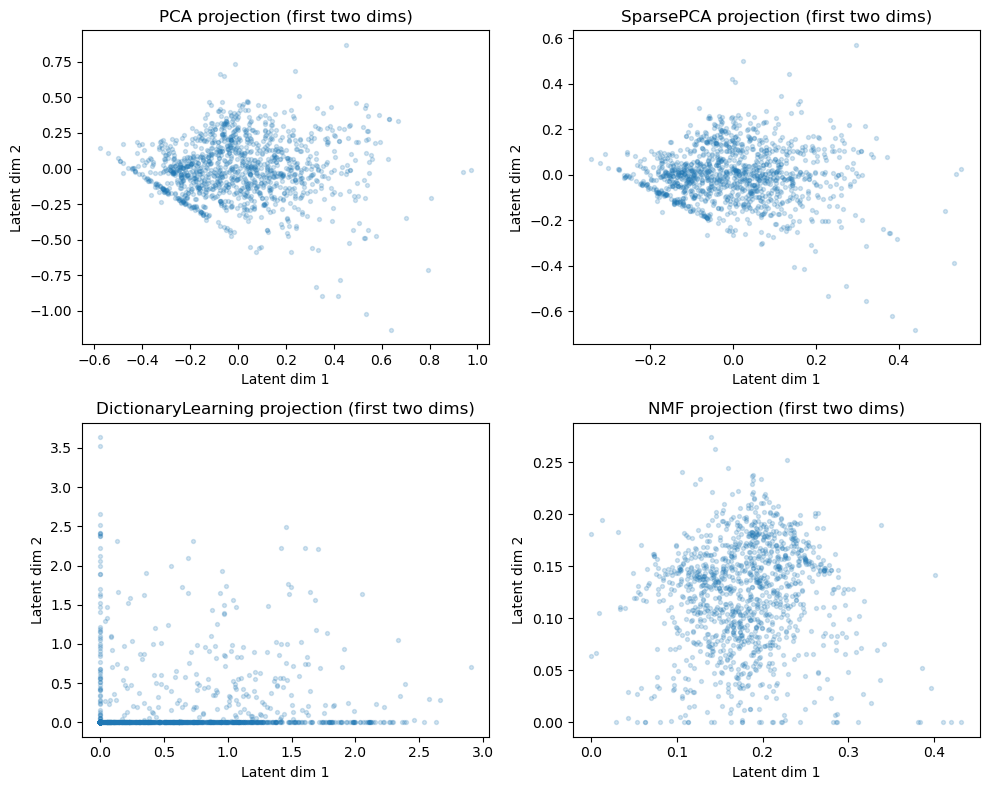

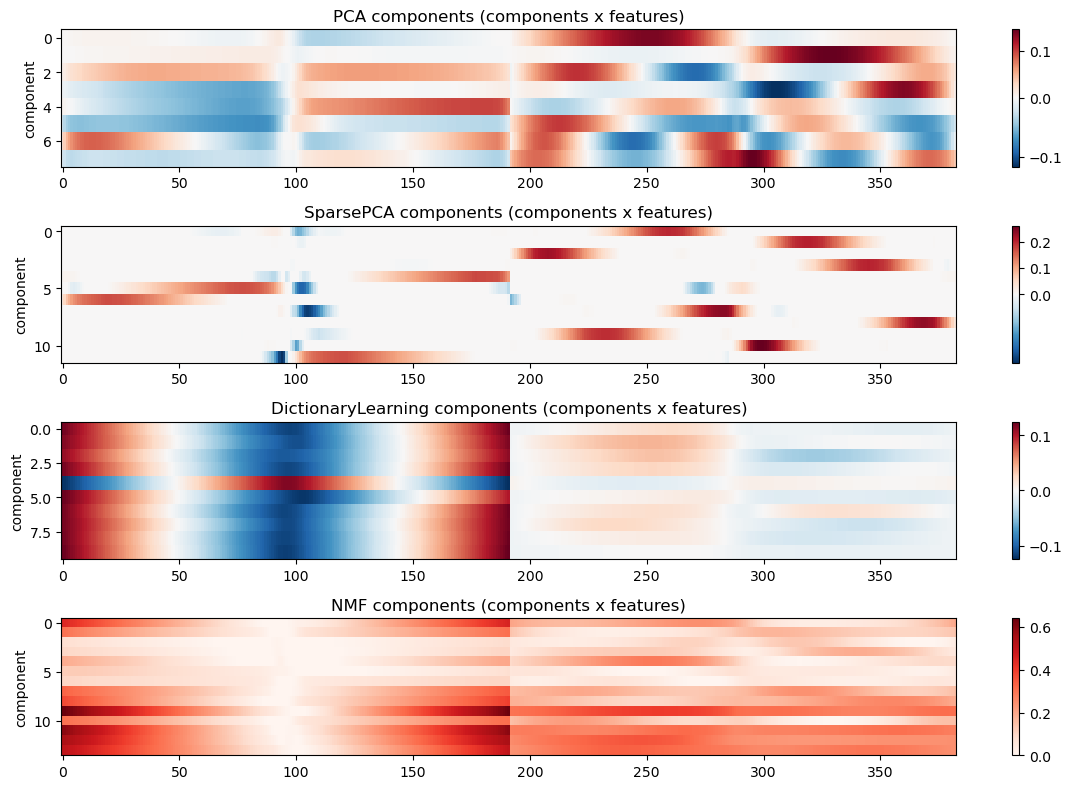

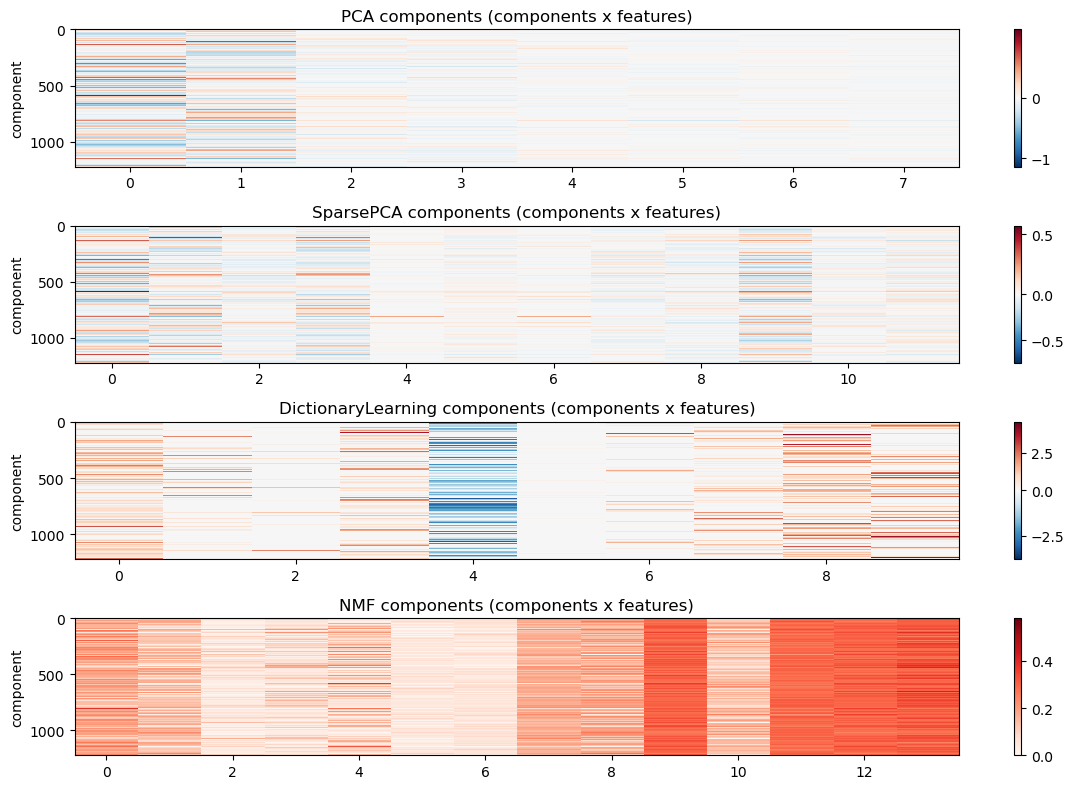

In [25]:
# Comparison: first-two latent projections and component heatmaps for each method
from sklearn.decomposition import PCA

models_info = {}
# PCA (reuse estimator from above if present, otherwise fit)
pca = PCA(n_components=8, random_state=42)
Z_pca = pca.fit_transform(data)
models_info['PCA'] = {'Z': Z_pca, 'components': pca.components_}

# SparsePCA (use Z_sp, W_sp computed earlier)
models_info['SparsePCA'] = {'Z': Z_sp, 'components': W_sp}

# DictionaryLearning: use W as Z and H as components
models_info['DictionaryLearning'] = {'Z': Z_dl, 'components': W_dl}

# NMF: use W as Z (already non-negative)
models_info['NMF'] = {'Z': Z_nmf, 'components': W_nmf}

# Plot the first-two latent projections
plt.figure(figsize=(10,8))
for i, (name, info) in enumerate(models_info.items()):
    plt.subplot(2,2,i+1)
    Z = info['Z']
    plt.scatter(Z[:,0], Z[:,1], alpha=0.2, s=8)
    plt.xlabel('Latent dim 1')
    plt.ylabel('Latent dim 2')
    plt.title(f'{name} projection (first two dims)')
plt.tight_layout()
plt.show()

# Plot heatmaps of component/weight matrices (showing first 120 features for clarity)
plt.figure(figsize=(12,8))
for i, (name, info) in enumerate(models_info.items()):
    comps = info['components']
    # ensure comps is (n_components, n_features)
    if comps.ndim == 1:
        comps = comps[None, :]
    plt.subplot(4,1,i+1)
    if np.any(comps < 0):
        plt.imshow(reorder_indices(comps), aspect='auto', cmap='RdBu_r', interpolation='nearest',
                   norm=TwoSlopeNorm(vmin=comps.min(), vcenter=0, vmax=comps.max()))
    else:
        plt.imshow(reorder_indices(comps), aspect='auto', cmap='Reds', interpolation='nearest')
    plt.colorbar()
    plt.title(f'{name} components (components x features)')
    plt.ylabel('component')
plt.tight_layout()
plt.show()

# Plot heatmaps of component/weight matrices (showing first 120 features for clarity)
plt.figure(figsize=(12,8))
for i, (name, info) in enumerate(models_info.items()):
    Z_map = info['Z']
    # ensure comps is (n_components, n_features)
    if Z_map.ndim == 1:
        Z_map = Z_map[None, :]
    plt.subplot(4,1,i+1)
    if np.any(Z_map < 0):
        plt.imshow(Z_map, aspect='auto', cmap='RdBu_r', interpolation='nearest',
                   norm=TwoSlopeNorm(vmin=Z_map.min(), vcenter=0, vmax=Z_map.max()))
    else:
        plt.imshow(Z_map, aspect='auto', cmap='Reds', interpolation='nearest')
    plt.colorbar()
    plt.title(f'{name} components (components x features)')
    plt.ylabel('component')
plt.tight_layout()
plt.show()